#Trabalho Prático 1

##Exercicio a)


I)

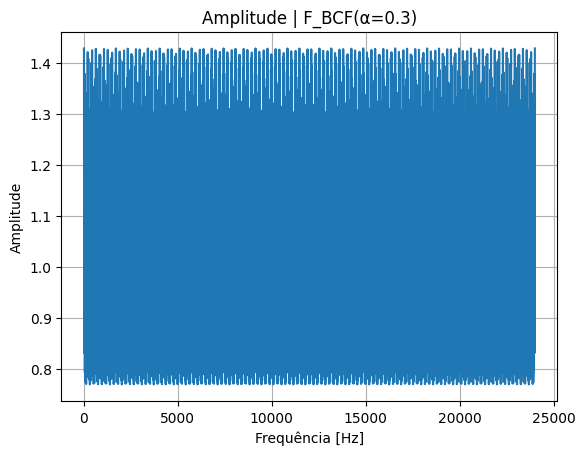

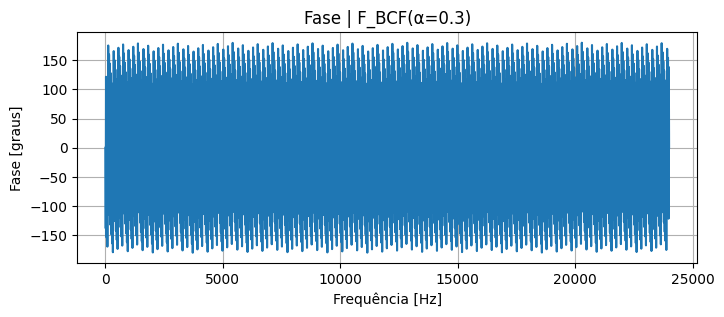

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


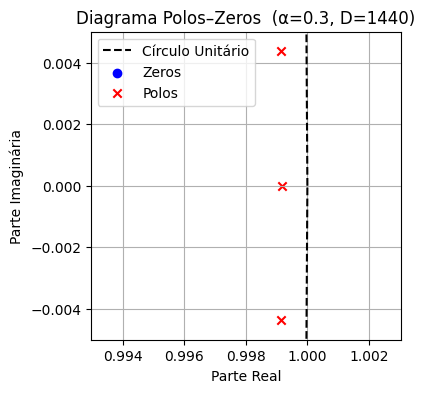

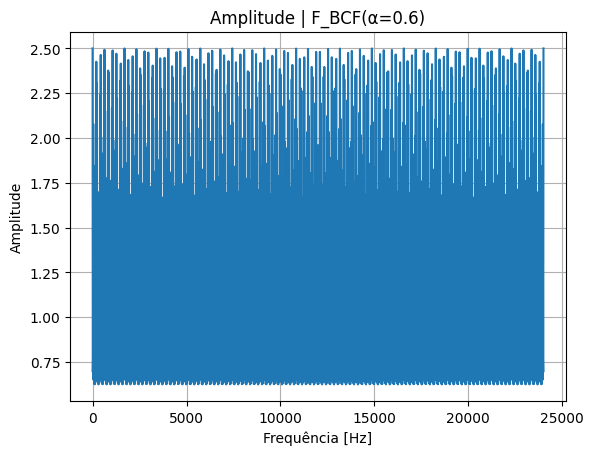

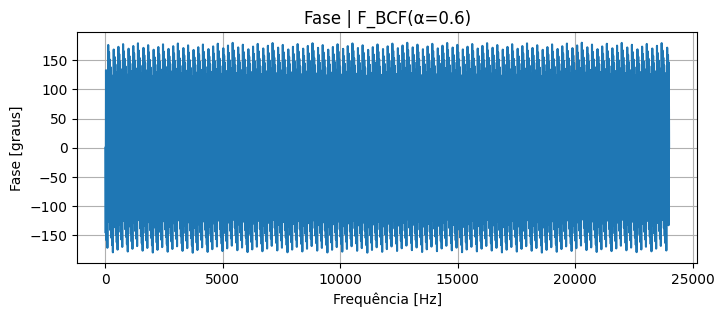

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


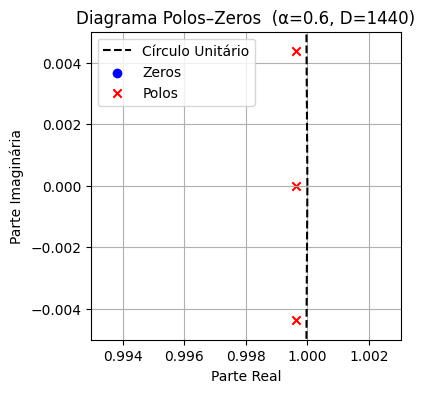

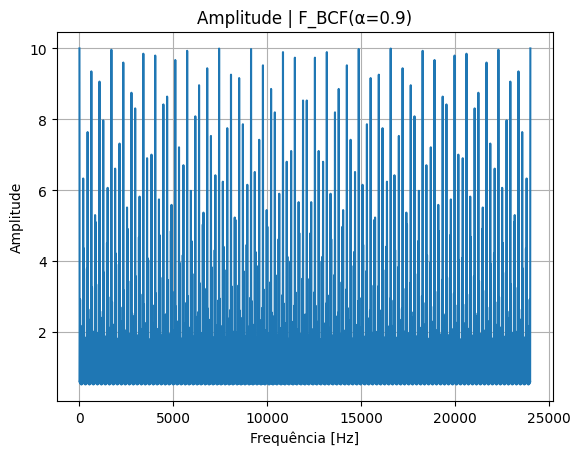

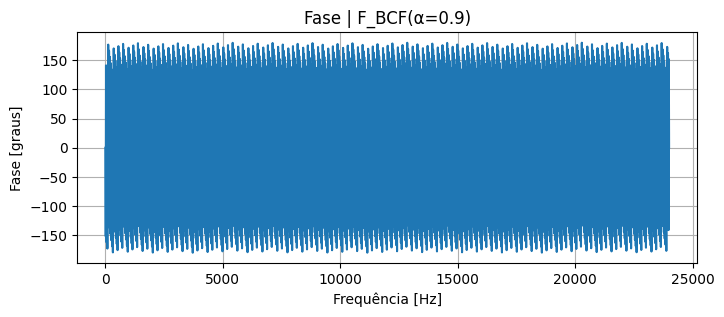

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


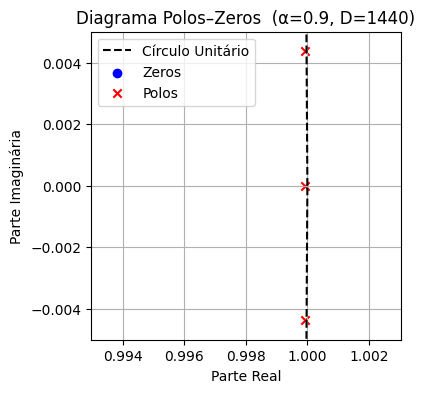

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# Feedback Comb Filter
# F_BCF(α, D_c) = z^{-D_c} / (1 - α z^{-D_c})
# ==============================

# --- Parâmetros ---
fs = 48000          # frequência de amostragem [Hz]
delay_ms = 30       # atraso (milissegundos)
D = int(round(delay_ms * fs / 1000))  # atraso em amostras

# Conjunto de ganhos a analisar separadamente
alpha_list = [0.3, 0.6, 0.9]

# Grelha de frequências
N = 2048
w = np.linspace(0, np.pi, N)
f = w * fs / (2 * np.pi)

# --- Função para calcular polos e zeros ---
def poloszeros(alpha, D):
    # Zeros: D zeros na origem
    zeros = np.zeros(D, dtype=complex)
    # Polos: soluções de z^D = α
    r = np.abs(alpha)**(1/D)
    angles = 2 * np.pi * np.arange(D) / D
    poles = r * np.exp(1j * angles)
    return zeros, poles

# --- Loop principal ---
for alpha in alpha_list:
    # Função de transferência no domínio da frequência
    ejwD = np.exp(-1j * w * D)
    H = ejwD / (1 - alpha * ejwD)

    # Resposta em amplitude e fase
    H_abs = np.abs(H)
    H_ang = np.angle(H) * 180 / np.pi

    # ---------- Gráfico de amplitude ----------
    plt.figure(figsize=(8, 3))
    plt.plot(f, H_abs)
    plt.title(f"Amplitude | F_BCF(α={alpha})")
    plt.xlabel("Frequência [Hz]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    # ---------- Gráfico de fase ----------
    plt.figure(figsize=(8, 3))
    plt.plot(f, H_ang)
    plt.title(f"Fase | F_BCF(α={alpha})")
    plt.xlabel("Frequência [Hz]")
    plt.ylabel("Fase [graus]")
    plt.grid(True)
    plt.show()

    # ---------- Diagrama Polos–Zeros ----------
    z, p = poloszeros(alpha, D)
    plt.figure(figsize=(4, 4))
    theta = np.linspace(0, 2*np.pi, 512)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', label='Círculo Unitário')
    plt.scatter(np.real(z), np.imag(z), marker='o', color='b', label='Zeros')
    plt.scatter(np.real(p), np.imag(p), marker='x', color='r', label='Polos')
    plt.axis('equal')
    plt.xlabel("Parte Real")
    plt.ylabel("Parte Imaginária")
    plt.title(f"Diagrama Polos–Zeros  (α={alpha}, D={D})")
    plt.legend()
    plt.grid(True)
    plt.xlim(0.995, 1.001)
    plt.ylim(-0.005, 0.005)
    plt.show()


II)

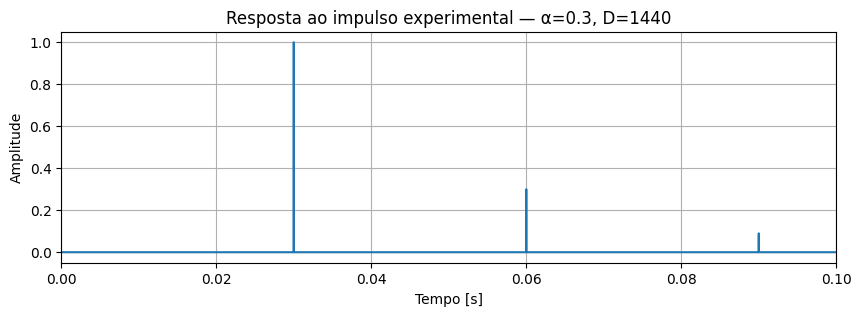

Guardado resposta ao impulso experimental em impulse_FBCF_alpha0.3_D1440_fs48000.wav


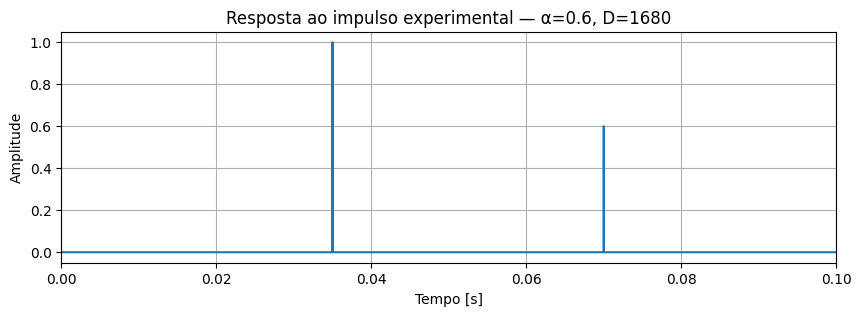

Guardado resposta ao impulso experimental em impulse_FBCF_alpha0.6_D1680_fs48000.wav


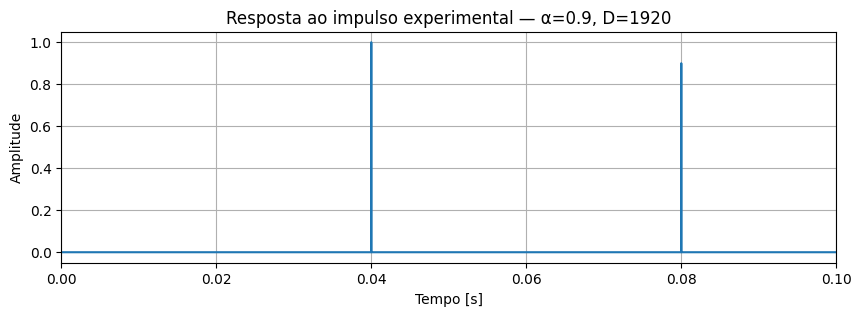

Guardado resposta ao impulso experimental em impulse_FBCF_alpha0.9_D1920_fs48000.wav


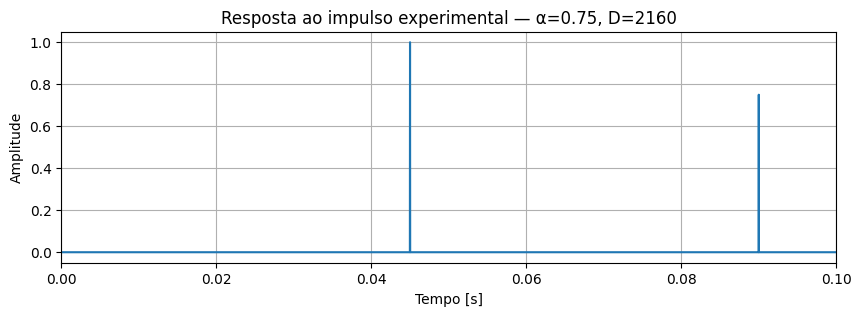

Guardado resposta ao impulso experimental em impulse_FBCF_alpha0.75_D2160_fs48000.wav


Guardado resposta ao impulso do comb-bank em impulse_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000.wav


Exercício II concluído: respostas impulsionais individuais e do comb-bank geradas, gravadas e reproduzidas.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import soundfile as sf
from IPython.display import Audio, display

# ==============================
# Exercício II: Resposta ao impulso experimental
# - calcula resposta ao impulso aplicando um delta
# - plota a resposta
# - guarda como WAV
# - reproduz inline
# ==============================

fs = 48000
# Usar o mesmo conjunto de 4 combs do Exercício III para consistência
delays_ms = [30, 35, 40, 45]
D_list = [int(round(dms * fs / 1000)) for dms in delays_ms]
alphas = [0.3, 0.6, 0.9, 0.75]

# comprimento do delta/resposta (vê-se decaimento) — usa maior D para garantir cobertura
L = 8 * max(D_list) if max(D_list)>0 else 1024

delta = np.zeros(L, dtype=np.float32)
delta[0] = 1.0

# --- Função utilitária local (mesma forma usada em Ex.III) ---
def apply_fbcf_impulse(alpha, D, L):
    b = np.hstack([np.zeros(D), [1.0]]).astype(np.float32)
    a = np.hstack([[1.0], np.zeros(D-1), [-alpha]]).astype(np.float32)
    from scipy.signal import lfilter
    return lfilter(b, a, delta)

# Calcular e guardar respostas impulsionais individuais e a resposta somada (combbank)
h_combbank = np.zeros(L, dtype=np.float32)
for alpha, D in zip(alphas, D_list):
    h_exp = apply_fbcf_impulse(alpha, D, L)
    # Plot - resposta ao impulso no domínio do tempo
    t = np.arange(len(h_exp)) / fs
    plt.figure(figsize=(10,3))
    plt.plot(t, h_exp)
    plt.title(f"Resposta ao impulso experimental — α={alpha}, D={D}")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.xlim(0, min(0.1, t[-1]))  # mostra os primeiros 100 ms por defeito
    plt.show()

    # Guardar como WAV (normalizado para evitar clipping)
    h_save = h_exp / (np.max(np.abs(h_exp)) + 1e-12)
    fname = f"impulse_FBCF_alpha{alpha}_D{D}_fs{fs}.wav"
    sf.write(fname, h_save.astype(np.float32), fs)
    print('Guardado resposta ao impulso experimental em', fname)

    # Reproduzir inline (nota: reprodução funciona no Jupyter)
    display(Audio(h_save, rate=fs))

    # acumular na resposta do banco
    h_combbank[:len(h_exp)] += h_exp

# Normalizar e guardar a resposta impulsional do comb-bank (soma dos 4 combs)
h_cb_save = h_combbank / (np.max(np.abs(h_combbank)) + 1e-12)
fname_cb = f"impulse_FBCF_combbank_alphas{'-'.join(str(a).replace('.', 'p') for a in alphas)}_delays{'-'.join(str(d) for d in delays_ms)}_fs{fs}.wav"
sf.write(fname_cb, h_cb_save.astype(np.float32), fs)
print('Guardado resposta ao impulso do comb-bank em', fname_cb)
display(Audio(h_cb_save, rate=fs))

print('Exercício II concluído: respostas impulsionais individuais e do comb-bank geradas, gravadas e reproduzidas.')


III) Impulso e sinais de teste

Neste bloco geramos a resposta ao impulso (entrada delta), comparamos com a resposta teórica, guardamos o impulso como WAV e aplicamos o filtro a sinais de teste: seno, chirp e ruído branco. Não é usado o módulo `os`; usamos `pathlib.Path` para manipular caminhos.

In [4]:
import numpy as np
from scipy.signal import lfilter
from scipy.signal import chirp
import soundfile as sf

# ==============================
# Exercício III: sinais de teste (seno, chirp, ruído) — comb-bank (4 combs)
# Implementa um banco de 4 Comb-filters em paralelo (soma das saídas)
# Guarda ficheiros WAV estéreo (L=dry, R=wet) e tenta processar audio.wav se existir
# Não usa os/pathlib — apenas nomes simples de ficheiros
# ==============================

fs = 48000
# Para corresponder ao diagrama: usamos 4 comb-filters em paralelo
# Os combs tipicamente usam delays entre 30 e 45 ms
delays_ms = [30, 35, 40, 45]  # em ms — quatro atrasos diferentes para o banco
D_list = [int(round(dms * fs / 1000)) for dms in delays_ms]
# ganhos (α) — um por comb; escolha razoável para demonstração
alphas = [0.3, 0.6, 0.9, 0.75]

dur = 2.0
N = int(dur * fs)
t = np.arange(N) / fs

# sinais de teste
sine = 0.6 * np.sin(2*np.pi*1000*t).astype(np.float32)
chirp_sig = 0.6 * chirp(t, f0=100, f1=6000, t1=dur, method='linear').astype(np.float32)
noise = 0.3 * np.random.randn(N).astype(np.float32)

# --- Funções utilitárias ---
def apply_fbcf(x, alpha, D):
    """Aplica F_BCF(alpha, D) a um sinal 1D e retorna o resultado"""
    b = np.hstack([np.zeros(D), [1.0]]).astype(np.float32)
    a = np.hstack([[1.0], np.zeros(D-1), [-alpha]]).astype(np.float32)
    return lfilter(b, a, x)

def combbank_wet(x, alphas, D_list):
    """Soma em paralelo as saídas dos comb-filters para obter o sinal 'wet'.
    Recebe uma lista de ganhos 'alphas' e uma lista de atrasos em amostras 'D_list'."""
    if len(alphas) != len(D_list):
        raise ValueError('alphas e D_list devem ter o mesmo comprimento')
    wet = np.zeros_like(x, dtype=np.float32)
    for a, D in zip(alphas, D_list):
        wet += apply_fbcf(x, a, D)
    # Normalizar para evitar clipping (preserva a forma relativa)
    max_abs = np.max(np.abs(wet))
    if max_abs > 0:
        wet = wet / (max_abs + 1e-12)
    return wet

alphas_tag = "-".join(str(a).replace('.', 'p') for a in alphas)
delays_tag = "-".join(str(d) for d in delays_ms)

# Processar sinais de teste: gravar um ficheiro estéreo por sinal (L=dry, R=wet comb-bank)
for name, sig in [('sine1k', sine), ('chirp', chirp_sig), ('noise', noise)]:
    wet = combbank_wet(sig, alphas, D_list)
    mix = np.stack([sig, wet], axis=1)
    mix = mix / (np.max(np.abs(mix)) + 1e-12)
    outname = f"{name}_FBCF_combbank_alphas{alphas_tag}_delays{delays_tag}_fs{fs}_stereo.wav"
    sf.write(outname, mix.astype(np.float32), fs)
    print('Guardado', outname)

# Se existir audio.wav, tenta processá-lo com o mesmo comb-bank (mono-mix -> L=dry, R=wet)
try:
    audio, sf_fs = sf.read('audio.wav', always_2d=True)
    if sf_fs != fs:
        # Aviso simples: não reamostramos automaticamente
        print(f'AVISO: audio.wav tem taxa {sf_fs}Hz diferente de {fs}Hz — será processado sem resample.')
    audio_mono = np.mean(audio, axis=1).astype(np.float32)
    wet_audio = combbank_wet(audio_mono, alphas, D_list)
    mix_audio = np.stack([audio_mono, wet_audio[:len(audio_mono)]], axis=1)
    mix_audio = mix_audio / (np.max(np.abs(mix_audio)) + 1e-12)
    out_audio = f"audio_FBCF_combbank_alphas{alphas_tag}_delays{delays_tag}_fs{fs}_stereo.wav"
    sf.write(out_audio, mix_audio.astype(np.float32), fs)
    print('Guardado', out_audio)
except Exception as e:
    print('audio.wav não encontrado ou não pôde ser lido; ficheiro ignorado. (Detalhe:', e, ')')

print('Exercício III concluído: sinais de teste processados com comb-bank (paralelo somado) e gravados na pasta do projeto.')


Guardado sine1k_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000_stereo.wav
 sine1k_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000_stereo.wav
Guardado chirp_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000_stereo.wav
Guardado chirp_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000_stereo.wav
Guardado noise_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000_stereo.wav
AVISO: audio.wav tem taxa 44100Hz diferente de 48000Hz — será processado sem resample.
Guardado noise_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000_stereo.wav
AVISO: audio.wav tem taxa 44100Hz diferente de 48000Hz — será processado sem resample.
Guardado audio_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000_stereo.wav
Exercício III concluído: sinais de teste processados com comb-bank (paralelo somado) e gravados na pasta do projeto.
Guardado audio_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000_stereo.wav
Exe